In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVR
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
import joblib

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("../../data/processed/final_dataset.csv")
df

,Unnamed: 0,Brand,CPU Name,CPU Mark,GPU Name,GPU Mark,Monitor,Width,Height,RAM,Storage Amount,OS,Weight,Price
0,0,HP,AMD Ryzen 5 5500U,13144.0,Intel UHD Graphics,1476.0,17.3,1920,1080,32.0,512.0,Windows 11,1.77,733.50
1,1,HP,Intel Core i7 1165G7 2.80GHz,10346.0,Intel Iris Xe,2690.0,15.6,1920,1080,12.0,256.0,Windows 11,1.77,886.78
2,2,HP,Intel Core i3 1115G4 3.00GHz,6132.0,Intel UHD Graphics,1476.0,15.6,1920,1080,8.0,256.0,Windows 10,2.00,375.00
3,3,HP,Intel Core i5 4302Y 1.60GHz,2028.0,Intel UHD Graphics,1476.0,12.5,1366,768,8.0,256.0,Windows 10,0.98,209.98
4,4,HP,Intel Core i9 13900H,29690.0,Intel Iris Pro Graphics 6200,1449.0,16.0,3840,2400,64.0,2048.0,Windows 11,1.75,4816.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9200,9200,Dell,Intel Core i5 1135G7 2.40GHz,9891.0,Intel HD Graphics 620,926.0,15.6,1920,1080,32.0,1024.0,Windows 11,1.88,572.09
9201,9201,Dell,Intel Core i7 2620M 2.70GHz,2443.0,Intel Arc,4253.0,13.0,1920,1080,16.0,256.0,Windows 11,0.77,999.99
9202,9202,Apple,Apple M3 Pro 11 Core,23805.0,Intel Iris Xe,3013.0,14.2,3024,1964,36.0,4096.0,Windows 10,1.60,3599.00
9203,9203,Lenovo,Intel Core i7 1250U,12421.0,Intel HD Graphics 620,926.0,14.0,1920,1080,16.0,256.0,Windows 10,1.77,515.00


In [3]:
df.drop(df.columns[0], axis=1, inplace=True)

# Filter Brand
df["Brand"] = df["Brand"].apply(lambda x: x.lower())
brands = df["Brand"].value_counts()
df = df[df["Brand"].isin(brands[brands>7].index.tolist())]
df["Brand"] = df["Brand"].replace({
    "gigabyte": "other",
    "razer": "other",
    "rokc": "other",
    "best notebooks": "other"
})
df[df["Brand"]=="apple"]["OS"].value_counts()
df.loc[df["Brand"] == "apple", "OS"] = "MacOS"

# Filter CPU Brand
df["CPU Brand"] = df["CPU Name"].str.split().apply(lambda x: x[0].lower())
id2 = df["CPU Brand"].value_counts()
df = df[df["CPU Brand"].isin(id2[id2> 22].index)]

# Filter GPU Brand
df["GPU Brand"] = df["GPU Name"].str.split().apply(lambda x: x[0].lower())
id3 = df["GPU Brand"].value_counts()
df = df[df["GPU Brand"].isin(id3[id3>5].index)]
df["GPU Brand"].replace("256mb", "radeon", inplace=True)
df["GPU Brand"].replace("t550", "t500", inplace=True)
df["GPU Brand"].replace("geforce3", "geforce", inplace=True)
df.drop("CPU Name", axis=1, inplace=True)
df.drop("GPU Name", axis=1, inplace=True)

# Filter Monitor
df = df[df["Monitor"]>10.5]
df = df[df["Monitor"]<20]

# Filter Width & Height
df = df[df["Width"]>100]
df = df[df["Width"]>1300]

# Filter RAM
df = df[df["RAM"]>3]

# Filter Storage
df = df[df["Storage Amount"]>=32]
df = df[df["Storage Amount"]<16000]

# Filter Weight
df = df[df["Weight"]<7.1]
df = df[df["Weight"]>0.3]

# Filter Price
df = df[df["Price"]>150]
df = df[df["Price"]<6500]

# Filter OS
df["OS"] = df["OS"].replace({
    "ChromeOS": "Chrome OS",
    "No OS": "Windows 10",
    "Windows 8.1": "Windows 8"
})
id4 = df["OS"].value_counts()
df = df[df["OS"].isin(id4[id4>5].index)]

In [4]:
df

,Brand,CPU Mark,GPU Mark,Monitor,Width,Height,RAM,Storage Amount,OS,Weight,Price,CPU Brand,GPU Brand
0,hp,13144.0,1476.0,17.3,1920,1080,32.0,512.0,Windows 11,1.77,733.50,amd,intel
1,hp,10346.0,2690.0,15.6,1920,1080,12.0,256.0,Windows 11,1.77,886.78,intel,intel
2,hp,6132.0,1476.0,15.6,1920,1080,8.0,256.0,Windows 10,2.00,375.00,intel,intel
3,hp,2028.0,1476.0,12.5,1366,768,8.0,256.0,Windows 10,0.98,209.98,intel,intel
4,hp,29690.0,1449.0,16.0,3840,2400,64.0,2048.0,Windows 11,1.75,4816.61,intel,intel
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9200,dell,9891.0,926.0,15.6,1920,1080,32.0,1024.0,Windows 11,1.88,572.09,intel,intel
9201,dell,2443.0,4253.0,13.0,1920,1080,16.0,256.0,Windows 11,0.77,999.99,intel,intel
9202,apple,23805.0,3013.0,14.2,3024,1964,36.0,4096.0,MacOS,1.60,3599.00,apple,intel
9203,lenovo,12421.0,926.0,14.0,1920,1080,16.0,256.0,Windows 10,1.77,515.00,intel,intel


In [5]:
columns = ["Brand", "OS", "CPU Brand", "GPU Brand"]
for col in columns:
    df = pd.get_dummies(df, columns=[col])
df

,CPU Mark,GPU Mark,Monitor,Width,Height,RAM,Storage Amount,Weight,Price,Brand_acer,...,CPU Brand_intel,GPU Brand_geforce,GPU Brand_geforce2,GPU Brand_intel,GPU Brand_nvidia,GPU Brand_quadro,GPU Brand_radeon,GPU Brand_rtx,GPU Brand_ryzen,GPU Brand_t500
0,13144.0,1476.0,17.3,1920,1080,32.0,512.0,1.77,733.50,0,...,0,0,0,1,0,0,0,0,0,0
1,10346.0,2690.0,15.6,1920,1080,12.0,256.0,1.77,886.78,0,...,1,0,0,1,0,0,0,0,0,0
2,6132.0,1476.0,15.6,1920,1080,8.0,256.0,2.00,375.00,0,...,1,0,0,1,0,0,0,0,0,0
3,2028.0,1476.0,12.5,1366,768,8.0,256.0,0.98,209.98,0,...,1,0,0,1,0,0,0,0,0,0
4,29690.0,1449.0,16.0,3840,2400,64.0,2048.0,1.75,4816.61,0,...,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9200,9891.0,926.0,15.6,1920,1080,32.0,1024.0,1.88,572.09,0,...,1,0,0,1,0,0,0,0,0,0
9201,2443.0,4253.0,13.0,1920,1080,16.0,256.0,0.77,999.99,0,...,1,0,0,1,0,0,0,0,0,0
9202,23805.0,3013.0,14.2,3024,1964,36.0,4096.0,1.60,3599.00,0,...,0,0,0,1,0,0,0,0,0,0
9203,12421.0,926.0,14.0,1920,1080,16.0,256.0,1.77,515.00,0,...,1,0,0,1,0,0,0,0,0,0


In [6]:
df1 = df

In [7]:
target_corr = df.corr()["Price"].apply(abs).sort_values()

SELECTED_FEATURES = 17
selected_features = list(target_corr[-SELECTED_FEATURES:].index)

limited_df = df[selected_features]

In [ ]:
X, y = limited_df.drop("Price", axis=1), limited_df["Price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=28)

columns_to_scale = ["Weight", "Monitor", "RAM", "Storage Amount", "GPU Mark", "Width", "Height", "CPU Mark"]
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled[columns_to_scale] = scaler.fit_transform(X_train_scaled[columns_to_scale])

X_test_scaled = X_test.copy()
X_test_scaled[columns_to_scale] = scaler.fit_transform(X_test_scaled[columns_to_scale])
knn = KNeighborsRegressor()
knn.fit(X_train_scaled, y_train)


In [9]:
knn = KNeighborsRegressor()
knn.fit(X_train_scaled, y_train)

KNeighborsRegressor()

In [10]:
y_pred = knn.predict(X_test_scaled)
print(mean_squared_error(y_test, y_pred))

144811.10931797678


In [11]:
pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})

,y_test,y_pred
3520,986.00,1487.396
6320,709.99,915.692
5754,999.99,1139.994
6478,1439.00,1560.368
7011,1979.00,2173.594
...,...,...
1363,1572.95,1140.302
7267,1999.00,1999.000
8155,519.79,587.110
2722,579.79,508.674


In [12]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [13]:
y_pred = knn.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')
print(f'Mean Absolute Percentage Error: {mape:.2f}%')

Mean Squared Error: 144811.11
Mean Absolute Percentage Error: 23.09%


In [14]:
model_filename = f"knn_model.pkl"
joblib.dump(knn, model_filename)

scaler_filename = f"save_scaler.pkl"
joblib.dump(scaler, scaler_filename)

print(f"Model saved as {model_filename}")

Model saved as knn_model.pkl


<AxesSubplot:>

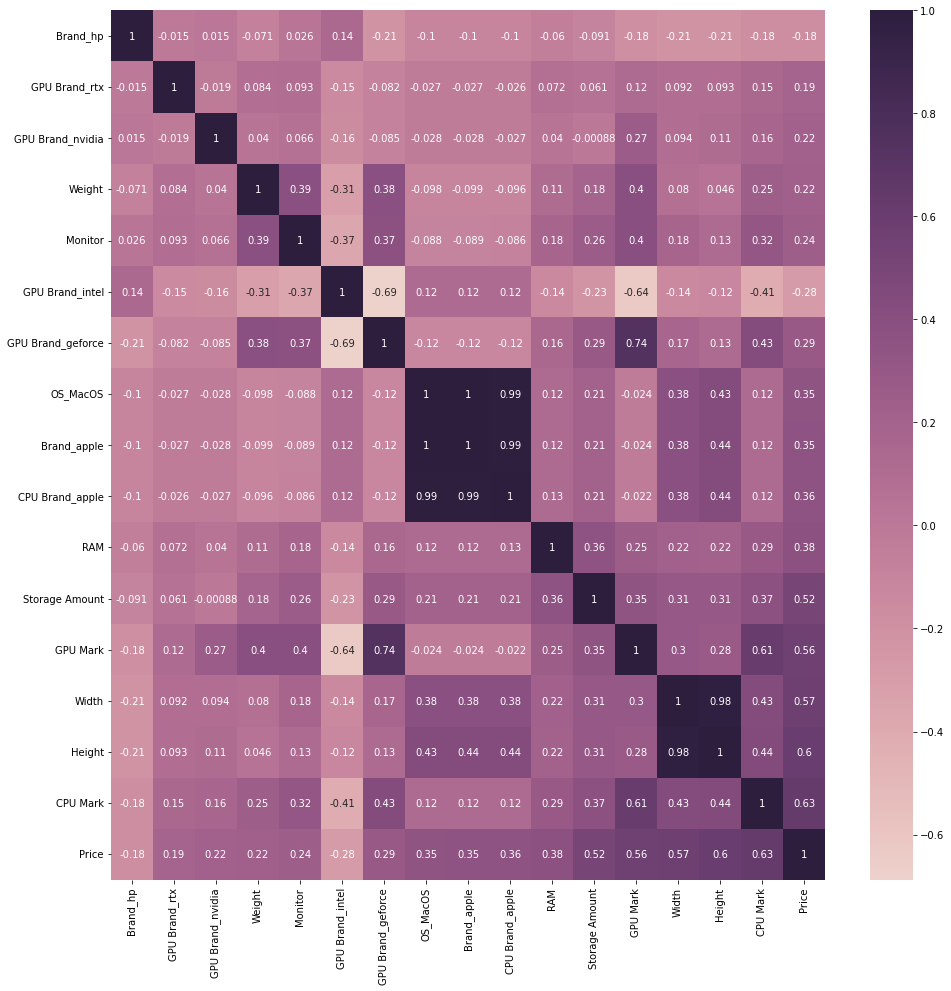

In [15]:
plt.figure(figsize=(16,16))
sns.heatmap(limited_df.corr(), annot=True, cmap=sns.cubehelix_palette(as_cmap=True))

<AxesSubplot:>

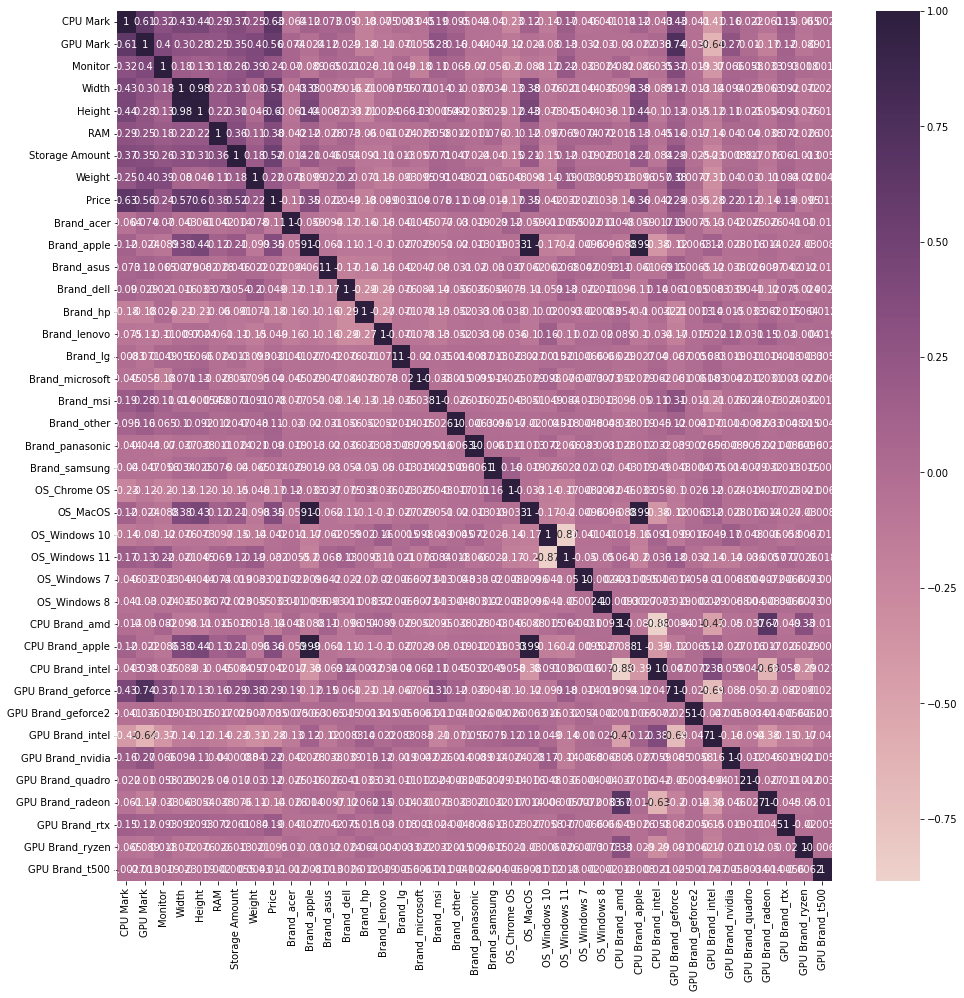

In [16]:
plt.figure(figsize=(16,16))
sns.heatmap(df.corr(), annot=True, cmap=sns.cubehelix_palette(as_cmap=True))